# Summary of endpoint plot for different physics variations

The goal of this plot is to show the change in the 'endpoint fractions' for low vs high Z for all the physics variations explored
I.e., 

$$
\Delta f_{endpoint, i} = f_{endpoint, i}(high Z) - f_{endpoint, i}(low Z)
$$

where i represents the different possible outcomes: Stellar mergers, BBH systems, Merging BBH, BHNS systems, Merging BHNS, NSNS systems, Merging NSNS, WD systems, Massless Remnant, Other



In [1]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec

# add run_data path to sys
import sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir = os.path.expanduser("~") 
compas_v = "v03.01.02" # "v02.46.01/"#v02.35.02/"
datar_root =  f"{home_dir}/ceph/CompasOutput/{compas_v}/"


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



## Start with collecting the data

First define the necessary functions to load the data, and count the relevant numbers/objects

In [2]:
#####################################
# Take the base potential DCO progenitor table
def load_potentialDCO(sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'):
    """_summary_

    Args:
        sim_name (str): simulation to load
        prog_table_name (str): name of pot DCO table to load (default ='potential_DCO_progenitors_Allinfo.h5')

    Returns:
        potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors (pandas tables)
    """
    if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
        potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
        print('Table exists, reading in... ')

        potential_DCO_progenitors.reset_index(drop=True, inplace=True)

        with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
            DCO = All_data['BSE_Double_Compact_Objects']
            st1 = DCO['Stellar_Type(1)'][()]
            st2 = DCO['Stellar_Type(2)'][()]
            dco_merger = DCO['Merges_Hubble_Time'][()]  
            DCO_seed = DCO['SEED'][()]
            # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
            BBH_bool = np.logical_and(st1 == 14,st2 == 14)
            BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                                    np.logical_and(st1 == 14,st2 == 13) )
            NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
            merger_bool = dco_merger == 1

            # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
            potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
            potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
            potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]

        return potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors

    else:
        print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')
        return None, None, None, None

        

#####################################
def get_endpoint_numbers(table):
    """_summary_

    Args:
        table (pandas table): potential_DCO_progenitors

    Returns:
        numpers of systems/events per metallicity
        N_tot_DCO_prog,                             total potential DCO progenitors per Z
        N_unbound, N_mergers,                       The number that is unbound, and the number of stellar mergers
        N_BBH, , N_BHNS, N_NSNS,                    counts of BBH, BHNS, NSNS 
        N_mergingBBH, N_mergingBHNS, N_mergingNSNS  counts BBH, BHNS, NSNS that merge within a Hubble time
        N_WD,                                       systems containing a white dwarf
        N_massless_rem,                             systems containing a massless remnant
        other_bool                                  anything else?
    """

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size()

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
    N_mergers       = grouped_byZ['Merger'].apply(lambda x: (x==1).sum())

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger = np.logical_and(table['Unbound'] == 0, table['Merger'] == 0)
    DCO_merger      = (table['Merges_Hubble_Time'] == 1)

    N_BBH           = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 
    N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 

    N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())
    N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())

    N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
    N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )

    N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
    N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() ) 


    # IDK whats going on here?
    not_unbound         = table['Unbound'] == 0
    not_merger          = table['Merger'] == 0
    not_BBH             = ~np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14)
    not_NSBH            = ~np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 13))
    not_NSNS            = ~np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 13)
    not_massless_rem    = ~(np.logical_or(table['Stellar_Type(1)'] == 15, table['Stellar_Type(2)'] == 15))
    not_WD              = ~(np.logical_or(table['Stellar_Type(1)'].isin([10, 11, 12]), table['Stellar_Type(2)'].isin([10, 11, 12])))

    other_bool = not_unbound* not_merger * not_BBH * not_NSBH * not_NSNS * not_massless_rem * not_WD
    # Check if there are thing that are both listed as BBH and unbound
    BBH_and_unbound = (np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14) * (table['Unbound'] == 1)  )
    print('BBH and unbound', BBH_and_unbound.sum())

    return  N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool


### Now create a class to store all the information we need

this should make the plotting a lot easier and faster

In [4]:
# class to store simulation data
class Simulation:
    def __init__(self, sim_name, label, channel_key, results_table):
        self.sim_name = sim_name
        self.channel_key = channel_key
        self.label = label
        self.results_table = self.collect_results(sim_name, channel_key)

    def collect_results(self, sim_name = 'NewWinds_RemFryer2012', channel_key = ''):
        # Load the potential DCO progenitors
        potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors = load_potentialDCO(sim_name, prog_table_name = f'potential_DCO_progenitors_Allinfo{channel_key}.h5')

        # List of tables of pot DCO progenitors
        titles  = ["BHBH", "BHNS", "NSNS"]
        dfs     = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

        # Initialize an empty dictionary to store the results
        results = {}

        # Loop over the dataframes and titles
        for df, title in zip(dfs, titles):
            print(f' {title} ')
            # Get the results from get_endpoint_numbers
            results[title] = get_endpoint_numbers(table = df)

        return results


# Dictionary to map simulation names to labels and colors we want to use in the plots
sim_name_label_dict = {
    'NewWinds_RemFryer2012': 'Fiducial', 
    'NewWinds_RemFryer2012_noCHE': 'no CHE',
    'NewWinds_RemMullerMandel': 'M&M remnant',
    'OldWinds_RemFryer2012': 'Old Winds',
    'NewWinds_RemFryer2012_WRBELCZYNSKI2010': 'Old WR winds',
    'NewWinds_RemFryer2012_noWRwinds': 'No WR winds',
    'NewWinds_RemFryer2012_strongWRwinds': 'strong WR winds',
    'NewWinds_RemFryer2012_noMSwinds': 'No MS winds',
    'RemFryer2012_NOwinds': 'No winds',
    'NewWinds_RemFryer2012_noBHkick': 'No BH kick',
    'NewWinds_RemFryer2012_noNSBHkick': 'No natal kicks',
    }

# List of channel keys to loop over
channel_keys = ['_stable', '_CE',  '_CHE'] # '_stable', '_CE', '_CHE', ''


########################################
# Loading and counting systems and then creating simulation objects
# This takes a lot of time, so we'll use multiprocessing to speed things up
# still takes about 2-3 min to run
import multiprocessing as mp

# Define a function to create a simulation object
def create_simulation(sim_name, channel_key):
    print(f'Working on {sim_name} with channel key {channel_key}...')

    sim_obj = Simulation(sim_name, sim_name_label_dict[sim_name], channel_key, None)
    return sim_obj

# Create a pool of workers
with mp.Pool(mp.cpu_count()) as pool:
    # Create a list of tuples, where each tuple contains a sim_name and a channel_key
    tasks = [(sim_name, key) for sim_name in sim_name_label_dict.keys() for key in channel_keys]
    
    # Apply create_simulation to every combination of sim_name and channel_key
    simulations = pool.starmap(create_simulation, tasks)



# # Define a function to create a simulation object
# def create_simulation(sim_name):
#     print(f'Working on {sim_name}...')

#     sim_obj = Simulation(sim_name, sim_name_label_dict[sim_name], channel_key, None)
#     return sim_obj


# # Create a pool of workers
# with mp.Pool(mp.cpu_count()) as pool:
#     simulations = pool.map(create_simulation, sim_name_label_dict.keys())


Working on NewWinds_RemFryer2012 with channel key _stable...Working on NewWinds_RemFryer2012 with channel key _CE...Working on NewWinds_RemFryer2012_noCHE with channel key _stable...Working on NewWinds_RemFryer2012_noCHE with channel key _CE...Working on NewWinds_RemMullerMandel with channel key _stable...Working on NewWinds_RemFryer2012 with channel key _CHE...
Working on NewWinds_RemFryer2012_noCHE with channel key _CHE...Working on NewWinds_RemMullerMandel with channel key _CE...Working on NewWinds_RemMullerMandel with channel key _CHE...Working on OldWinds_RemFryer2012 with channel key _stable...Working on OldWinds_RemFryer2012 with channel key _CE...Working on OldWinds_RemFryer2012 with channel key _CHE...


Working on NewWinds_RemFryer2012_WRBELCZYNSKI2010 with channel key _stable...

Working on NewWinds_RemFryer2012_WRBELCZYNSKI2010 with channel key _CE...





Working on NewWinds_RemFryer2012_WRBELCZYNSKI2010 with channel key _CHE...
Working on NewWinds_RemFryer2012_noWRwinds w

/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, 

BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
 BHBH 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
 BHBH 
 BHBH 
 BHBH 
 BHBH 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
 BHBH 
Table exists, reading in... 
 BHBH 
Table exists, reading in... 
 BHBH 
 BHBH 
BBH and unbound 154
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

Table exists, reading in... 
 BHBH 
 BHBH 
 BHBH 


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

 BHBH Table exists, reading in... 

BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

 BHBH 
 BHBH 


/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this war

BBH and unbound 988
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

 BHBH 


/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


BBH and unbound 25297
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


BBH and unbound 14800
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

BBH and unbound 0
BBH and unbound 22285

 BHNS BBH and unbound 996
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

Table exists, reading in... 
BBH and unbound 1001
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 24180
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),


Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
 BHBH Table exists, reading in... 

 BHBH 


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

 BHBH 


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())


BBH and unbound 22524
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),


 BHBH 

/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )



 BHBH 

/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )



BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, u

 BHBH 
BBH and unboundBBH and unbound  4026


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())


 NSNS 24180


/tmp/ipykernel_1226949/3286231880.py:75: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() )



 BHNS 


/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )
/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .gro

BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 1199
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:75: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() )
/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, 

Table exists, reading in... 
Table exists, reading in... 


/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),


BBH and unbound

/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


/tmp/ipykernel_1226949/3286231880.py:75: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() )


7389
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

Table exists, reading in... 
BBH and unbound 0


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

BBH and unbound 0
BBH and unbound 
8540
 NSNS  BHBH 
Table exists, reading in... 


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

 BHBH 
 BHBH 


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())


BBH and unbound 21793
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )


BBH and unboundBBH and unbound  09102

 NSNS  NSNS 



/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

 BHBH 
BBH and unbound 0
BBH and unbound 9102
 NSNS 
BBH and unbound 11518
 NSNS 
BBH and unbound 10093
 NSNS 
BBH and unbound 17179
 BHNS 
BBH and unbound 151
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unboundBBH and unbound  2169324

 BHNS  NSNS 

BBH and unbound 2551


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound BBH and unbound401 
21000
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


BBH and unbound 69
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 20997
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:75: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() )


BBH and unbound 

/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )


22150
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),


BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 2601


/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),


BBH and unbound 0


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound 0
BBH and unbound 70
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),


BBH and unbound 56
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


BBH and unbound 2032
BBH and unbound BHNS  
56
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 80
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )


BBH and unbound 3324
BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 616


/tmp/ipykernel_1226949/3286231880.py:75: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() )


 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound 22208


/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


 BHNS 
BBH and unbound

/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


 0
BBH and unbound 0

/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())


/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )


BBH and unboundBBH and unbound  00



/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound 13021
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 3324


/tmp/ipykernel_1226949/3286231880.py:85: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this

BBH and unbound 84
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )


BBH and unbound
 0
 NSNS 

/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound 20
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:86: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() )


BBH and unbound 0
BBH and unbound 0
BBH and unbound 5187
BBH and unbound 69
 BHNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0


/tmp/ipykernel_1226949/3286231880.py:79: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
/tmp/ipykernel_1226949/3286231880.py:82: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warn

BBH and unbound 0
 NSNS 


/tmp/ipykernel_1226949/3286231880.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
/tmp/ipykernel_1226949/3286231880.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  N_mergers       = grouped_byZ['Merger'].apply(lambd

BBH and unbound 0
BBH and unbound 4144
BBH and unbound 10894
 BHNS 
BBH and unbound 0
 NSNS 
BBH and unbound 51229
 BHNS 
BBH and unbound 0
BBH and unbound 8177
 NSNS 
Table exists, reading in... 
BBH and unbound 2290
Table exists, reading in... 
 BHBH 
 BHBH 
Table exists, reading in... 
 BHBH 
BBH and unbound 572
 BHNS 
Table exists, reading in... 
Table exists, reading in... 
 BHBH 
 BHBH 
BBH and unbound 24248
 BHNS 
BBH and unbound 3446
 NSNS 
BBH and unbound 572
 BHNS 
BBH and unbound 1552
BBH and unbound 6899
 NSNS 
BBH and unbound 180
Table exists, reading in... 
BBH and unbound 329
 BHNS 
BBH and unbound 3509
 NSNS 
 BHBH 
BBH and unbound 11133
 BHNS 
BBH and unbound 1382
 NSNS 
BBH and unbound 208
BBH and unbound 1885
 NSNS 
BBH and unbound 25
BBH and unbound 2220
BBH and unbound 339
 BHNS 
BBH and unbound 1432
 NSNS 
BBH and unbound 252


# Plot the Results! --> Per formation channel

/tmp/ipykernel_1226949/1477107373.py:81: UserWarning: You passed a edgecolor/edgecolors ('#b0c4dd') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
/tmp/ipykernel_1226949/1477107373.py:81: UserWarning: You passed a edgecolor/edgecolors ('#000000') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\


Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHBH, no CHE : No data for None 
Error for _CHE, BHNS, Fiducial : No data for Unbound Systems 
Error for _CHE, BHNS, Fiducial : No data for Stellar Mergers 
Error for _CHE, BHNS, Fiducial : No data for BHBH 
Error for _CHE, BHNS, Fiducial : No data for merging BHBH 
Error for _CHE, BHNS, Fiducial : No data for BHNS 
Error for _CHE, BHNS, Fiducial : No data for merging BHNS 
Error for _CHE, BHNS, Fiducial : No data for NSNS 
Error for _CHE, BHNS, Fiducial : No data for merging NSNS 
Error for _CHE, BHNS, Fiducial : No data for WD systems 

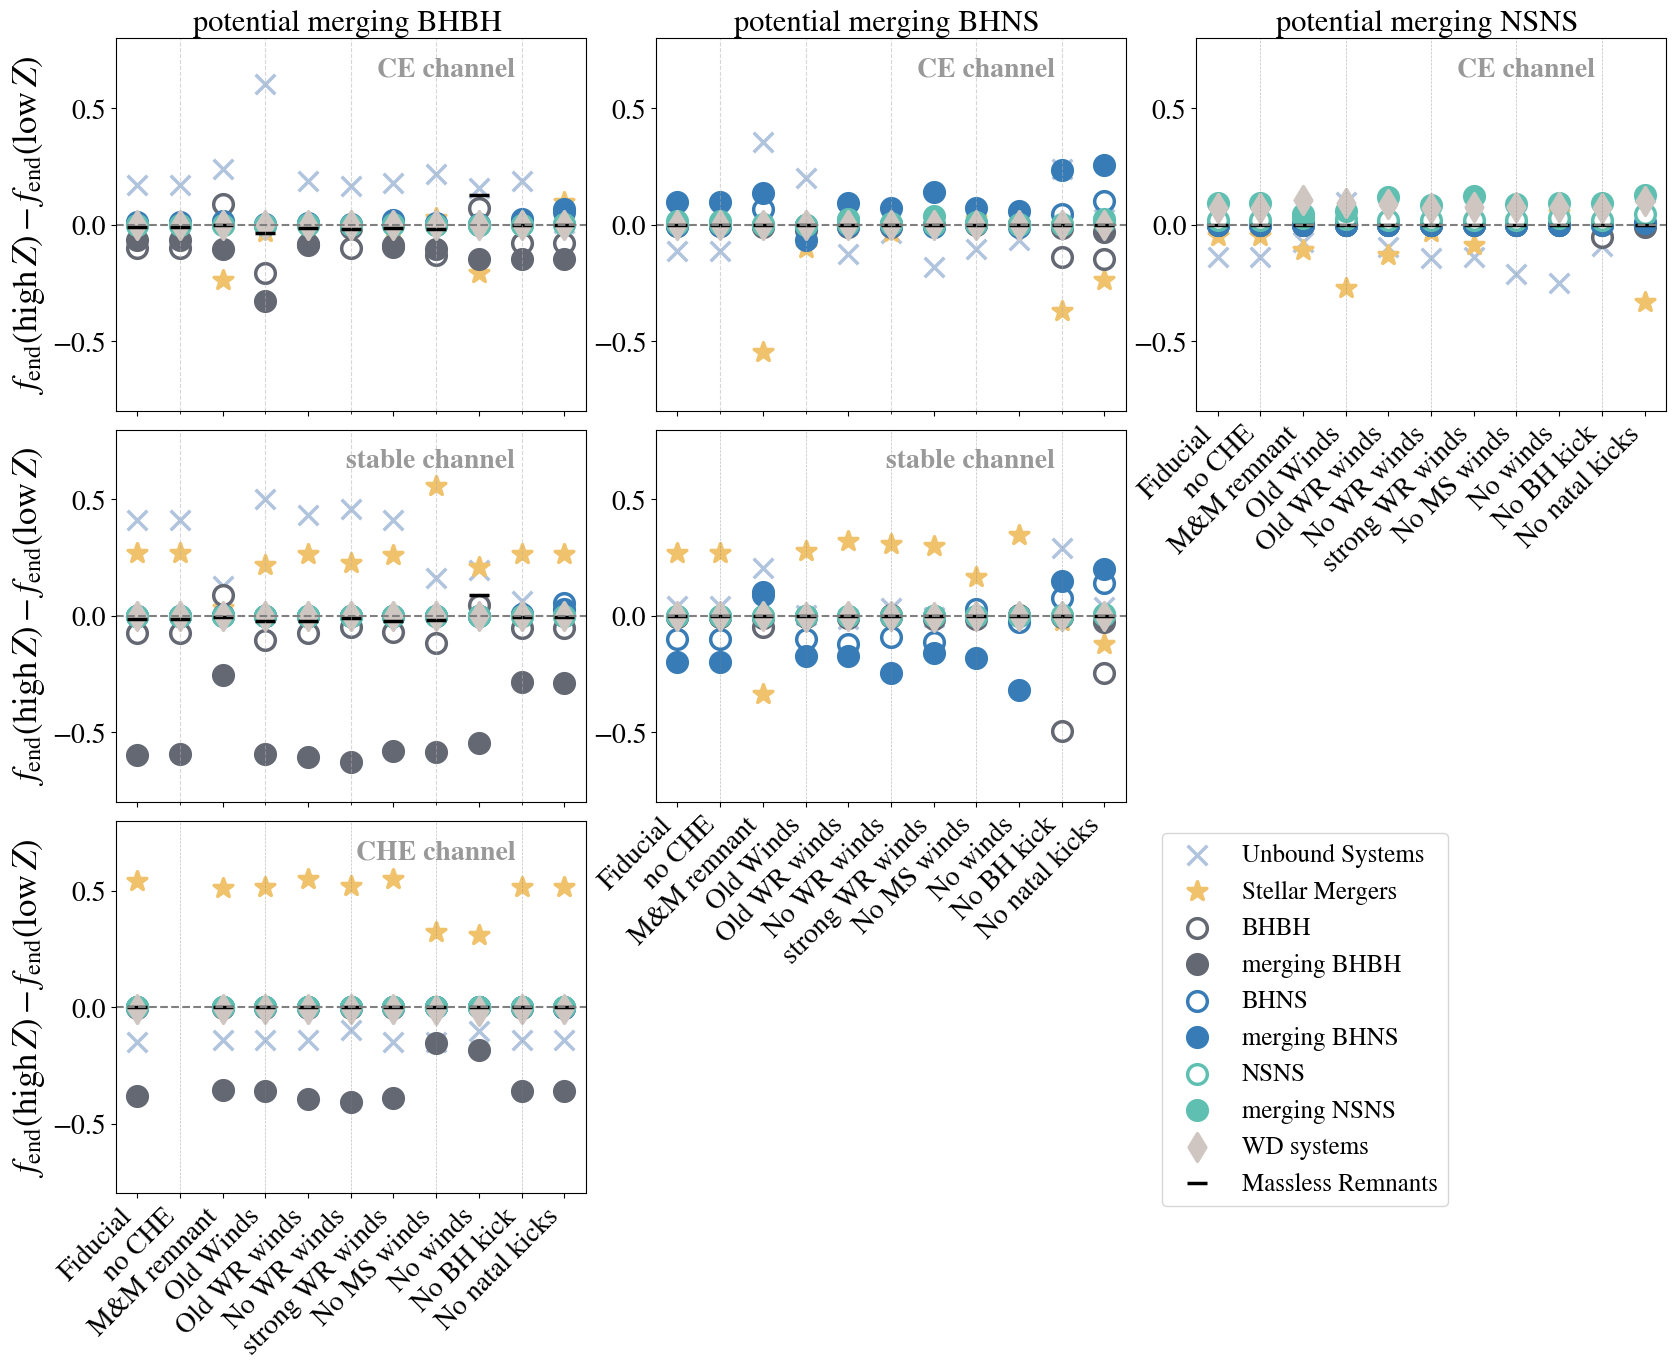

In [6]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 15))

# Create a GridSpec with 3 rows (CE, stable and CHE) and 3 columns (BBH, BHNS, NSNS)
gs = GridSpec(3, 3, figure=fig)
axes = [[fig.add_subplot(gs[j, i]) for i in range(3)] for j in range(3)]


 # Get all simulation labels
simulation_labels = sim_name_label_dict.values()

# Define your channel_key options
channel_keys = ['_CE', '_stable', '_CHE']

# And the DCO flavors we want to plot
titles  = ["BHBH", "BHNS", "NSNS"]

#############################################
# For every channel CE, stable, CHE, (rows)
for j, channel_key in enumerate(channel_keys):

    # print(f'Working on channel : {channel_key}')

    # Filter simulations with the current channel_key
    filtered_simulations = [sim for sim in simulations if sim.channel_key == channel_key]

    ########################################
    # For every DCO flavor (columns)
    for i, ax in enumerate(axes[j]):

        # Exclude chemically homogeneous channel for BHNS and NSNS
        if j == 2: # bottom row == chemically homogeneous channel
            if i > 0: # only works for BBHs!
                ax.set_visible(False)

        # exclude the stable channel for NSNS
        if j == 1: # middle row == stable channel
            if i == 2: # Is really super noisy for NSNS! --> exclude
                ax.set_visible(False)

        #Write the channel in the top left corner
        ax.text(0.85, 0.95, channel_key[1:] + ' channel', transform=ax.transAxes, fontsize=20, 
        ha = 'right', va='top', color = 'grey', weight = 'bold', alpha = 0.8)

        # print(f'Working on DCO flavor : {titles[i]}')

        ########################################
        # For every simulation/physics variation 
        for s, simulation in enumerate(filtered_simulations):
            # print(f' {simulation.sim_name}  {simulation.label}')

            # access the results from ths simulation fromt the big dictionary
            N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = simulation.results_table[titles[i]] # get_endpoint_numbers(table = df)

            # Define a dictionary to map the labels to their respective conditions, colors, and markers
            endpoint_dict = {
                'Unbound Systems': {'data': N_unbound, 'edgecolor': '#b0c4dd', 'color': '#b0c4dd', 'marker': 'x'},
                'Stellar Mergers': {'data': N_mergers, 'edgecolor': '#F0C26B', 'color': '#F0C26B', 'marker': '*'},
                'BHBH': {'data': N_BBH, 'edgecolor': '#646873', 'color': 'white', 'marker': 'o'},
                'merging BHBH': {'data': N_mergingBBH, 'edgecolor': '#646873', 'color': '#646873', 'marker': 'o'},
                'BHNS': {'data': N_BHNS, 'edgecolor': '#377CB7', 'color': 'white', 'marker': 'o'},
                'merging BHNS': {'data': N_mergingBHNS, 'edgecolor': '#377CB7', 'color': '#377CB7', 'marker': 'o'},
                'NSNS': {'data': N_NSNS, 'edgecolor': '#5FC0B2', 'color': 'white', 'marker': 'o'},
                'merging NSNS': {'data': N_mergingNSNS, 'edgecolor': '#5FC0B2', 'color': '#5FC0B2', 'marker': 'o'},
                'WD systems': {'data': N_WD, 'edgecolor': '#cfc6c2', 'color': '#cfc6c2', 'marker': 'd'},
                'Massless Remnants': {'data': N_massless_rem, 'edgecolor': '#000000', 'color': '#000000', 'marker': '_'}
            }

            # We will now plot f(highest metallicity) - f(lowest metallicity) / N_tot_DCO_prog
            # the key is the metallicity, N_tot_DCO_prog is the same at all Z
            for label, attributes in endpoint_dict.items():
                # Only label the first time
                label = label if s == 0 else None

                try:
                    # Plot f_high z - f_low z 
                    avg_high_z = (attributes['data'][0.030000] + attributes['data'][0.020000])/2 # average N of 2 highest Z
                    avg_low_z = (attributes['data'][0.000100] + attributes['data'][0.00017321])/2  # average N of 2 lowest Z

                    ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
                        marker= attributes['marker'], color=attributes['color'], edgecolor = attributes['edgecolor'], lw = 2.5,  s=200, label=label)
                except KeyError:
                    print(f'Error for {channel_key}, {titles[i]}, {simulation.label} : No data for {label} ')
                    ax.scatter(s, 0, s = 0)


        #############
        ## Plotvalues per ax
        ax.axhline(0, linestyle='--', color='gray')# Plot the null line
        ax.set_ylim(-0.8,0.8)

        # thin vertical lines at each xtick
        xticks = range(len(simulation_labels))
        ax.set_xticks(xticks[::2])
        ax.set_xticks(xticks, minor=True) # only do the grid every 2nd line (following minor ticks)
        ax.grid(axis='x', which='minor',  linestyle='--', alpha=0.5)



#############
for ax_row in axes:
    ax_row[0].set_ylabel(r'$f_{\mathrm{end}}(\mathrm{high} \, Z) - f_{\mathrm{end}}(\mathrm{low} \, Z)$', fontsize = 25)

# loop over top row to set titles
for a_i, ax in enumerate(axes[0]):
    ax.set_title(f'potential merging {titles[a_i]} ', fontsize = 22)
    # remove the xticks labels
    ax.set_xticklabels([])

# Remove middle row xticks
for ax in axes[1]:
    ax.set_xticklabels([]) 

# Set the x-tick labels to be the simulation labels
X_label_axes = [axes[2][0], axes[1][1], axes[0][2]]
for ax in X_label_axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(simulation_labels, rotation=45, ha='right') 
    # Manal grid lines because its being annoying
    for s in range(len(filtered_simulations)):
        if s % 2 != 0:
            ax.axvline(s, color='gray', linestyle='--', alpha=0.5, lw = 0.5)

axes[1][1].legend(bbox_to_anchor=(1.05, -0.05), loc='upper left', fontsize = 18, ncols = 1)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.15, hspace = 0.05)

plt.savefig(f'../plots/{compas_v}/Summary_end_of_evol_per_channel.pdf', bbox_inches='tight')

plt.show()

# Plot the results! -->  For All channels 

In [ ]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

simulation_labels = [simulation.label for simulation in simulations]  # Get all simulation labels

######################################
# Loop over the different DCO flavors
titles  = ["BBH", "BHNS", "NSNS"]
for i, ax in enumerate(axes):

    print(f'{titles[i]}')

    ######################################
    # Loop over the simulations
    for s, simulation in enumerate(simulations):
        print(f' {simulation.sim_name}  {simulation.label}')

        # results from the simulation
        N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = simulation.results_table[titles[i]] # get_endpoint_numbers(table = df)

        # Define a dictionary to map the labels to their respective conditions, colors, and markers
        endpoint_dict = {
            'Unbound Systems': {'data': N_unbound, 'edgecolor': '#b0c4dd', 'color': '#b0c4dd', 'marker': 'x'},
            'Stellar Mergers': {'data': N_mergers, 'edgecolor': '#F0C26B', 'color': '#F0C26B', 'marker': '*'},
            'BHBH': {'data': N_BBH, 'edgecolor': '#646873', 'color': 'white', 'marker': 'o'},
            'merging BHBH': {'data': N_mergingBBH, 'edgecolor': '#646873', 'color': '#646873', 'marker': 'o'},
            'BHNS': {'data': N_BHNS, 'edgecolor': '#377CB7', 'color': 'white', 'marker': 'o'},
            'merging BHNS': {'data': N_mergingBHNS, 'edgecolor': '#377CB7', 'color': '#377CB7', 'marker': 'o'},
            'NSNS': {'data': N_NSNS, 'edgecolor': '#5FC0B2', 'color': 'white', 'marker': 'o'},
            'merging NSNS': {'data': N_mergingNSNS, 'edgecolor': '#5FC0B2', 'color': '#5FC0B2', 'marker': 'o'},
            'WD systems': {'data': N_WD, 'edgecolor': '#cfc6c2', 'color': '#cfc6c2', 'marker': 'd'},
            'Massless Remnants': {'data': N_massless_rem, 'edgecolor': '#000000', 'color': '#000000', 'marker': '_'}
        }


        # We will now plot f(highest metallicity) - f(lowest metallicity) / N_tot_DCO_prog
        # the key is the metallicity, N_tot_DCO_prog is the same at all Z
        for label, attributes in endpoint_dict.items():
            # Only label the first time
            label = label if s == 0 else None

            # Plot f_high z - f_low z 
            avg_high_z = (attributes['data'][0.030000] + attributes['data'][0.020000])/2 # average N of 2 highest Z
            avg_low_z = (attributes['data'][0.000100] + attributes['data'][0.00017321])/2  # average N of 2 lowest Z

            ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
                marker= attributes['marker'], color=attributes['color'], edgecolor = attributes['edgecolor'], lw = 2.5,  s=200, label=label)

            # ax.scatter(s, (attributes['data'][0.030000] - attributes['data'][0.000100])/N_tot_DCO_prog[0.030000],\
            #     marker= attributes['marker'], color=attributes['color'], edgecolor = attributes['edgecolor'], s=200, label=label)

    #############
    ## Plotvalues per ax
    ax.axhline(0, linestyle='--', color='gray')# Plot the null line

    # Set the title and ylim
    ax.set_title(f'potential merging {titles[i]} ', fontsize = 22)
    ax.set_ylim(-0.6, 0.6)

    # Set the x-tick labels to be the simulation labels
    ax.set_xticks(range(len(simulation_labels)))
    ax.set_xticklabels(simulation_labels, rotation=45, ha = 'right')  # Rotate labels for better visibility if needed
    
    # ax.set_yscale('symlog')

#############
axes[0].set_ylabel(r'$f_{\mathrm{end}}(\mathrm{high} \, Z) - f_{\mathrm{end}}(\mathrm{low} \, Z)$', fontsize = 25)
# axes[0].set_ylabel(r'$\frac{f(Z=0.03) - f(Z=0.0001)}{N_{\rm{tot, pot DCO}}}$', fontsize = 30)
axes[1].legend(bbox_to_anchor=(0.5, 1.1), loc='lower center', fontsize = 18, ncols = 5)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.15)

plt.savefig(f'../plots/{compas_v}/Summary_end_of_evol.pdf', bbox_inches='tight')

plt.show()